# What is Pneumonia?
**Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.**
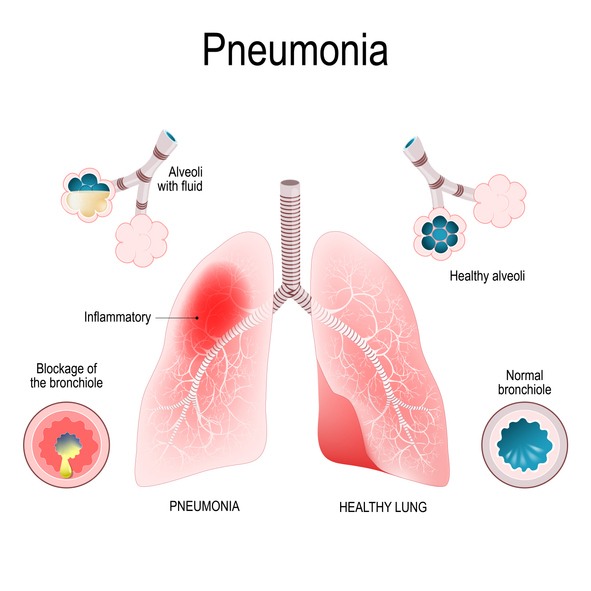

**Credits to: https://www.kaggle.com/code/madz2000/pneumonia-detection-using-cnn-92-6-accuracy**

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/atelectasis-images-split-1000/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Importing the necessary libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

Using TensorFlow backend.


# Description of the Pneumonia Dataset
**The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.**

In [3]:
labels = ['ATELECTASIS', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Loading the Dataset

In [4]:
train = get_training_data('/kaggle/input/atelectasis-images-split-1000/filtered_images_split/train')
test = get_training_data('/kaggle/input/atelectasis-images-split-1000/filtered_images_split/test')
val = get_training_data('/kaggle/input/atelectasis-images-split-1000/filtered_images_split/val')

# Data Visualization & Preprocessing

[[array([[  1,   1,   1, ...,   1,   1,   1],
       [163, 162, 133, ...,  96,  99, 105],
       [163, 161, 134, ...,  98, 101, 106],
       ...,
       [ 10,  10,   9, ..., 182, 179, 178],
       [ 10,  10,   9, ..., 182, 178, 178],
       [ 11,   9,   9, ..., 181, 178, 177]], dtype=uint8)
  0]
 [array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 101,  81,  62],
       [  0,   0,   0, ..., 102,  81,  64],
       [  0,   0,   0, ..., 105,  86,  62]], dtype=uint8)
  0]
 [array([[  3,   3,   3, ...,  19,  24, 203],
       [  3,   3,   3, ...,  16,  20, 187],
       [  3,   3,   3, ...,  13,  17, 169],
       ...,
       [ 72,  77,  84, ...,   3,   4,   3],
       [ 69,  75,  81, ...,   3,   4,   3],
       [ 66,  69,  78, ...,   3,   3,   3]], dtype=uint8)
  0]
 ...
 [array([[ 10,   9,  10, ...,   7,   7, 157],
       [  7,   7,   7, ...,   6,   7,   7],
       [  7,  

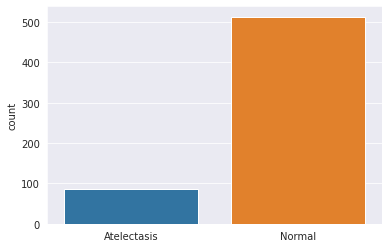

In [5]:
l = []
print(train)
for i in train:
    print(i,i[1])
    if(i[1] == 0):
        l.append("Atelectasis")
    else:
        l.append("Normal")

sns.set_style('darkgrid')
sns.countplot(l)        

**The data seems imbalanced . To increase the no. of training examples, we will use data augmentation**

**Previewing the images of both the classes**

Text(0.5, 1.0, 'NORMAL')

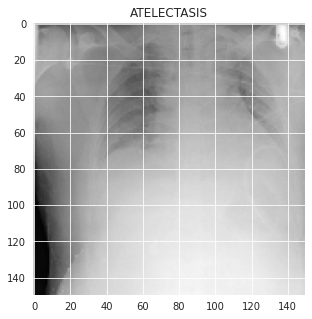

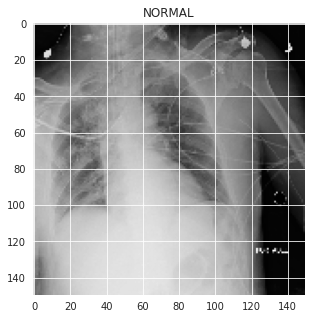

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [7]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [8]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [9]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Data Augmentation
**In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.**

In [10]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation, i choosed to :
1. Randomly rotate some training images by 30 degrees 
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width 
4. Randomly shift images vertically by 10% of the height 
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

# Training the Model

In [11]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 38, 64)       

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [13]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
19/19 [==============================] - 37s 2s/step - loss: 1.9092 - accuracy: 0.7967 - val_loss: 0.5594 - val_accuracy: 0.8100
Epoch 2/12
19/19 [==============================] - 36s 2s/step - loss: 0.4676 - accuracy: 0.8533 - val_loss: 0.1201 - val_accuracy: 0.8100
Epoch 3/12
19/19 [==============================] - 37s 2s/step - loss: 0.4785 - accuracy: 0.8550 - val_loss: 0.9944 - val_accuracy: 0.2900

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/12
19/19 [==============================] - 37s 2s/step - loss: 0.4189 - accuracy: 0.8550 - val_loss: 0.9241 - val_accuracy: 0.4300
Epoch 5/12
19/19 [==============================] - 36s 2s/step - loss: 0.4246 - accuracy: 0.8550 - val_loss: 0.6198 - val_accuracy: 0.5600

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/12
19/19 [==============================] - 35s 2s/step - loss: 0.4113 - accuracy: 0.8550 - val_loss: 0.5587 - val_accuracy: 0.680

In [14]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

300/300 [==============================] - 4s 14ms/step
Loss of the model is -  0.6305011324087779
300/300 [==============================] - 4s 14ms/step
Accuracy of the model is -  64.66666460037231 %


# Analysis after Model Training

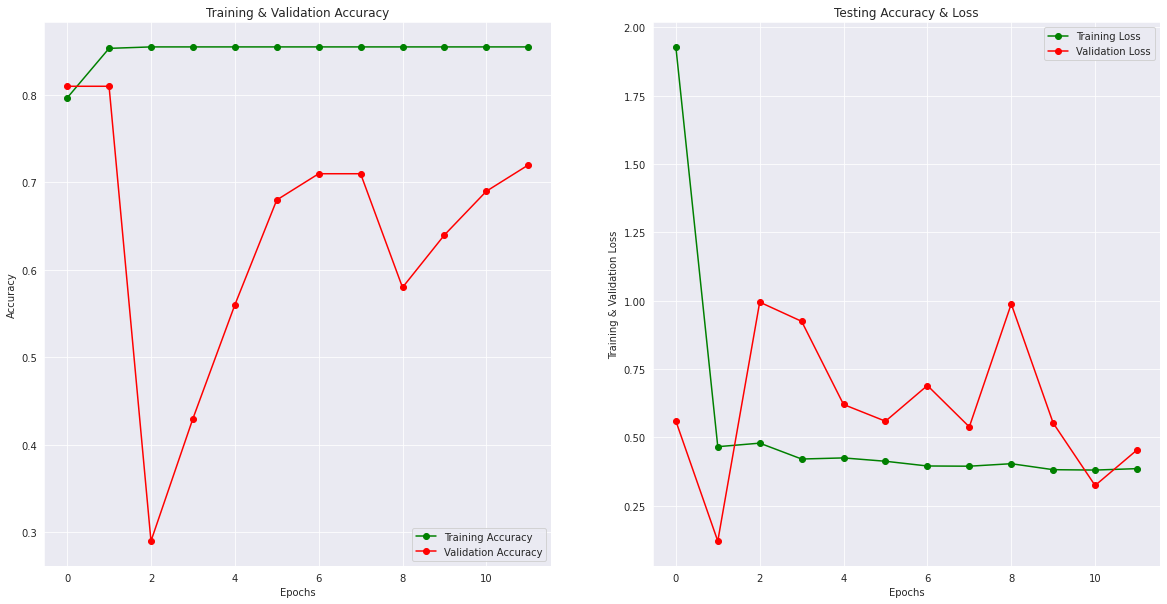

In [15]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [16]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int32)

In [17]:
print(classification_report(y_test, predictions, target_names = ['Atelectasis (Class 0)','Normal (Class 1)']))

                       precision    recall  f1-score   support

Atelectasis (Class 0)       0.13      0.30      0.18        40
     Normal (Class 1)       0.87      0.70      0.77       260

             accuracy                           0.65       300
            macro avg       0.50      0.50      0.48       300
         weighted avg       0.77      0.65      0.70       300



In [18]:
cm = confusion_matrix(y_test,predictions)
cm

array([[ 12,  28],
       [ 78, 182]])

In [19]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

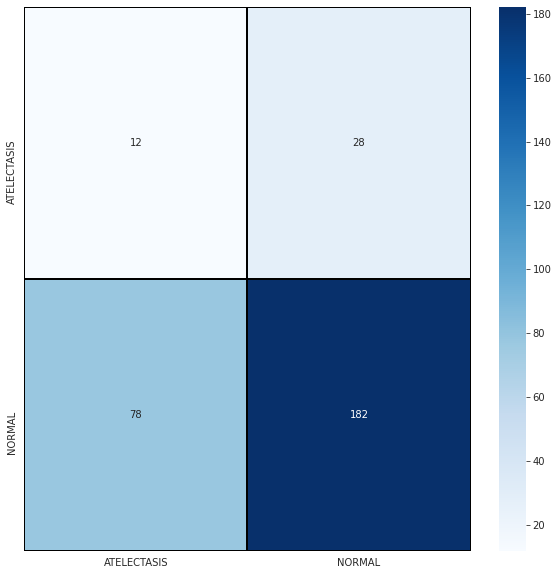

In [20]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [21]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

**Some of the Correctly Predicted Classes**

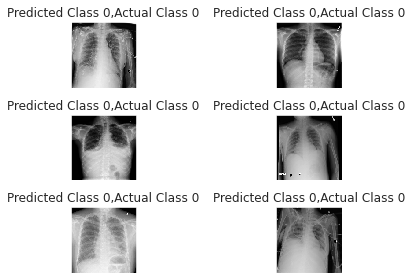

In [23]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Some of the Incorrectly Predicted Classes**

Atelectasis (Class 0) Normal (Class 1)


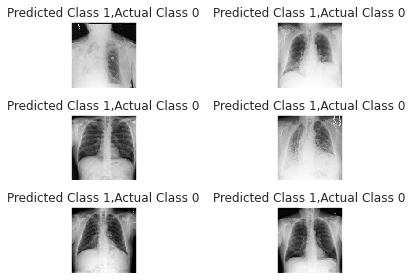

In [26]:
print('Atelectasis (Class 0)','Normal (Class 1)')
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1